In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import torch 
from torchvision import datasets, transforms

## Classificação

Vamos usar como exemplo o dataset MNIST de dígitos escritos a mão. É um excelente dataset para quem está aprendendo técnicas de reconhecimento de padrões em imagens, como descreve o próprio autor:<br>
http://yann.lecun.com/exdb/mnist/

O MNIST possui **10 classes**, os dígitos entre 0 e 9, como apresentado na imagem a seguir.

![](https://learnmachinelearning.files.wordpress.com/2017/08/mnist.png)

Ele faz parte dos datasets disponíveis através da biblioteca ```torchvision```<br>
https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST

Na padronização do Torchvision, podemos carregar o dataset com uma simples chamada de função. Cada elemento do MNIST é representado na forma ```(dado, rótulo)```. 

In [2]:
MNIST = datasets.MNIST('./',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())


dado, rotulo = MNIST[0]
print(type(dado), type(rotulo))

# Channel First: Padrão do torch
print(dado.size()) # C x H x W

<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])


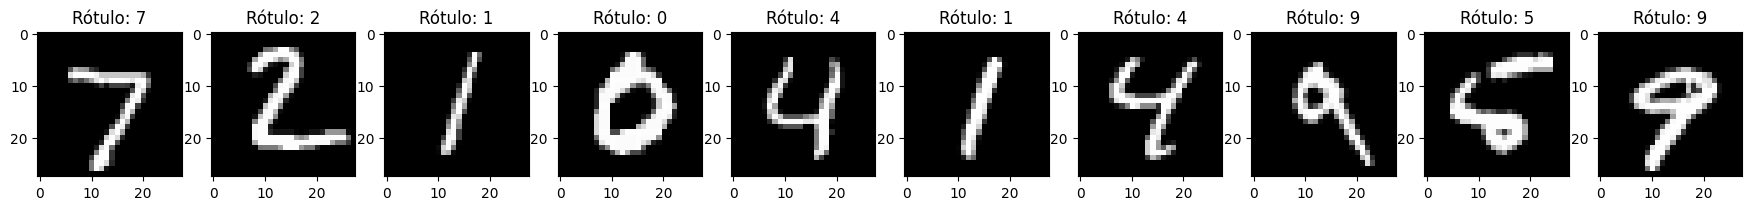

In [3]:
fig, axs = plt.subplots(1,10, figsize=(22, 4))
for i in range(10):
  dado, rotulo = MNIST[i]
  axs[i].imshow(dado[0], cmap='gray')
  axs[i].set_title('Rótulo: ' + str(rotulo))
plt.show()

> **Como deve ser a última camada de uma rede cujo objetivo é classificar os dados do MNIST?**
---



## Detecção

Para ilustrar o problema de detecção, usaremos o dataset PascalVOC 2012:<br> 
https://pjreddie.com/projects/pascal-voc-dataset-mirror/

O [PASCAL Visual Object Classes](https://en.wikipedia.org/wiki/PASCAL_Visual_Object_Classes) é um projeto que realiza competições para desenvolvedores que se interessam pelos desafios do reconhecimento de padrões em imagens. Dentre os desafios estão: detecção, segmentação, reconhecimento de ações, entre outros. <br>

Os dados de detecção podem ser encontrado no pacote Torchvision:<br>
https://pytorch.org/vision/stable/generated/torchvision.datasets.VOCDetection.html


In [4]:
datasets.voc.DATASET_YEAR_DICT["2012"]["url"] = (
    "http://data.brainchip.com/dataset-mirror/voc/VOCtrainval_11-May-2012.tar"
)

voc_detection = datasets.VOCDetection(
    root="./",
    image_set="train",
    download=True,
    transform=transforms.ToTensor(),
)

det_img, det_target = voc_detection[0]
print(type(det_img), type(det_target))


<class 'torch.Tensor'> <class 'dict'>


Imagens coloridas possuem **canais** de cor (RGB: *red, green blue*). <br>
Por padrão o PyTorch adota o formato *channel first*, ou seja **canal primeiro**, fazendo referência à dimensionalidade da imagem: **$C \times H \times W$**<br>

Já bilbiotecas de visualização, como o matplotlib, representam as imagens com o canal na última dimensão, por isso antes de plotar a imagem, precisamos organizar as dimensões. 

Dimensionalidade: torch.Size([3, 442, 500])


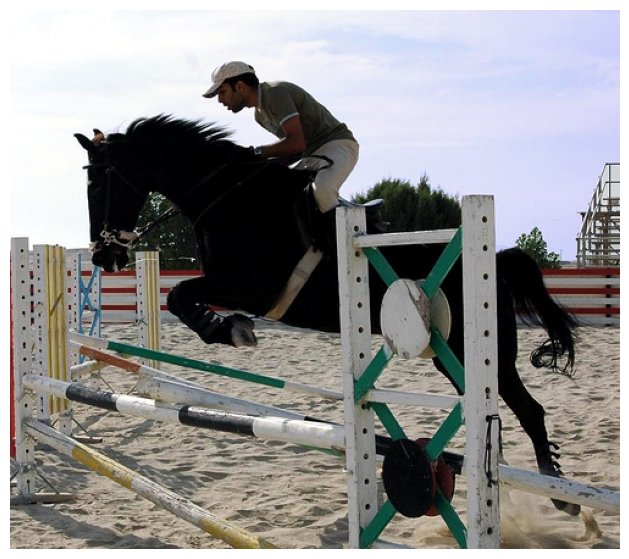

In [5]:
print('Dimensionalidade:', det_img.size())
det_img_vis = det_img.permute(1, 2, 0)

plt.figure(figsize=(8, 7))
plt.imshow(det_img_vis)
plt.axis('off')
plt.show()


In [6]:
det_target


{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

Estamos interessados no **bounding box** do rótulo, que numa tradução livre seria a "caixa delimitadora", um retângulo que define a localização do objeto na imagem. De acordo com o padrão de anotação do PascalVOC, o rótulo de um objeto pode ser acessado da seguinte forma:
```python
xmax, xmin, ymax, ymin = rotulo['annotation']['object'][0]['bndbox'].values()
```

Para visualizar o bounding box, usaremos os ```patches``` do matplotlib
```
rect = patches.Rectangle((xmin, ymin),w,h)
```

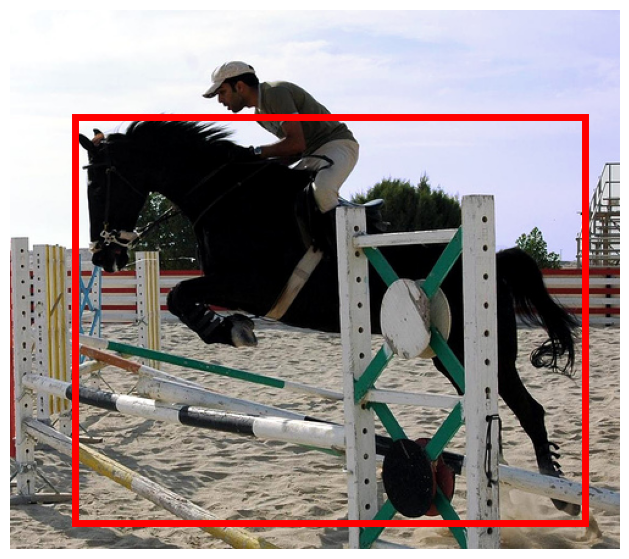

In [7]:
objects = det_target['annotation']['object']
if isinstance(objects, dict):
    objects = [objects]
bbox = objects[0]['bndbox']
xmax = int(bbox['xmax'])
xmin = int(bbox['xmin'])
ymax = int(bbox['ymax'])
ymin = int(bbox['ymin'])

fig, ax = plt.subplots(figsize=(8, 7))
ax.imshow(det_img_vis)

rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, linewidth=5, edgecolor='r')
ax.add_patch(rect)
ax.set_axis_off()

plt.show()


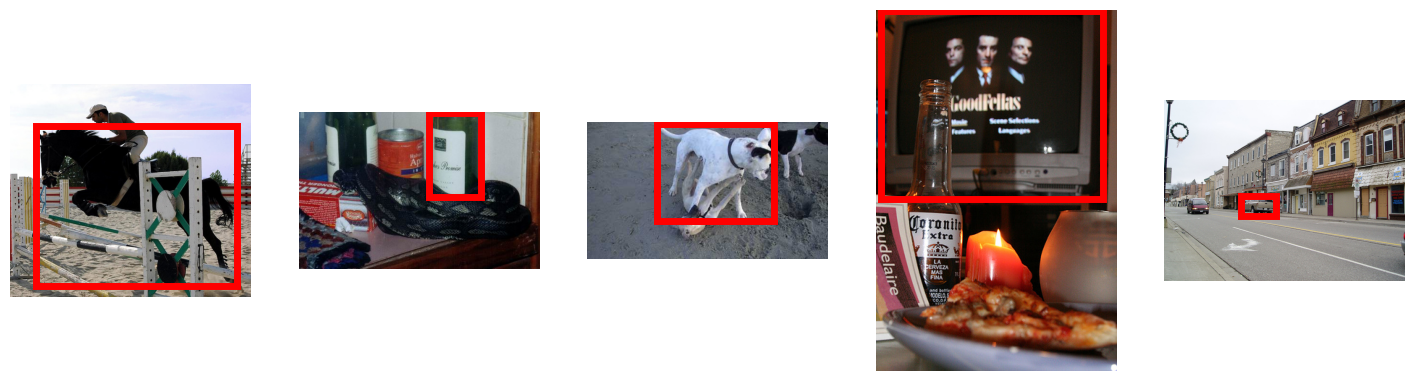

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(18, 7))
for i in range(5):
  img, target = voc_detection[i]
  img = img.permute(1, 2, 0)

  objects = target['annotation']['object']
  if isinstance(objects, dict):
    objects = [objects]
  bbox = objects[0]['bndbox']
  xmax = int(bbox['xmax'])
  xmin = int(bbox['xmin'])
  ymax = int(bbox['ymax'])
  ymin = int(bbox['ymin'])

  axs[i].imshow(img)

  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, linewidth=5, edgecolor='r')
  axs[i].add_patch(rect)
  axs[i].set_axis_off()


> **Como deve ser a última camada de uma rede cujo objetivo é detectar os objetos do PascalVOC?** <br>
---

## Segmentação

O PascalVOC também fornece rótulos de segmentação para algumas de suas imagens, então continuaremos utilizando este dataset. <br>
https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCSegmentation

A tarefa de segmentação consiste em uma **rotulação densa**, prevendo a localização exata dos objetos na cena a nível de píxel. A imagem a seguir apresenta ambos os rótulos de detecção e segmentação para esclarecer a diferença. 

![](https://www.researchgate.net/profile/Yizhou_Yu/publication/323410937/figure/fig5/AS:644201683361796@1530601058684/The-detection-and-semantic-segmentation-results-on-Pascal-VOC-2012-test-set-the-first_W640.jpg)

Os rótulos de segmentação em geral também são imagens, representando a máscara sobre o objeto que se deseja segmentar.

In [9]:
voc_segmentation = datasets.VOCSegmentation(
    root="./",
    image_set="train",
    download=False,
    transform=transforms.ToTensor(),
    target_transform=transforms.PILToTensor(),
)

seg_img, seg_mask = voc_segmentation[0]
print(type(seg_img), type(seg_mask))


<class 'torch.Tensor'> <class 'torch.Tensor'>


In [10]:
print(seg_img.size(), seg_mask.size())


torch.Size([3, 281, 500]) torch.Size([1, 281, 500])


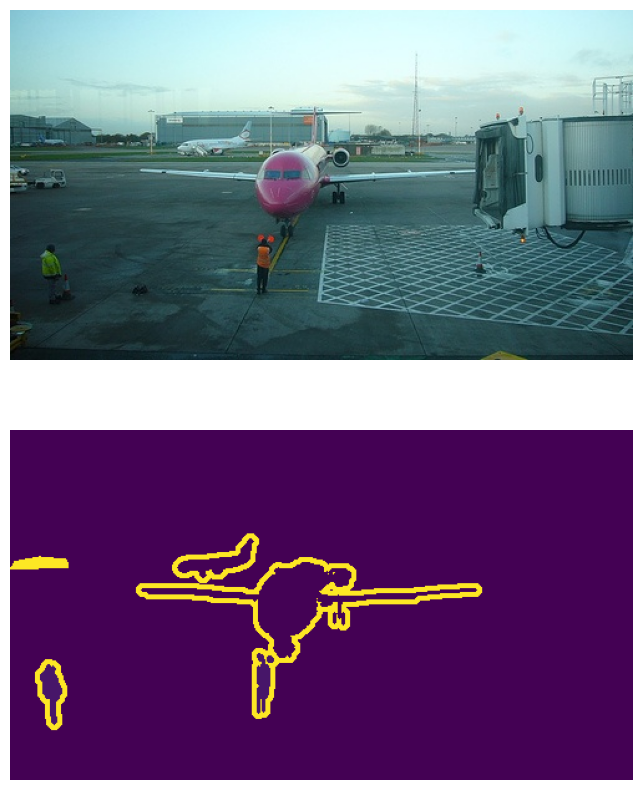

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

seg_img_vis = seg_img.permute(1, 2, 0).cpu().numpy()
seg_mask_vis = seg_mask.squeeze().cpu().numpy()

axs[0].imshow(seg_img_vis)
axs[0].axis('off')

axs[1].imshow(seg_mask_vis, cmap='viridis')
axs[1].axis('off')

plt.show()


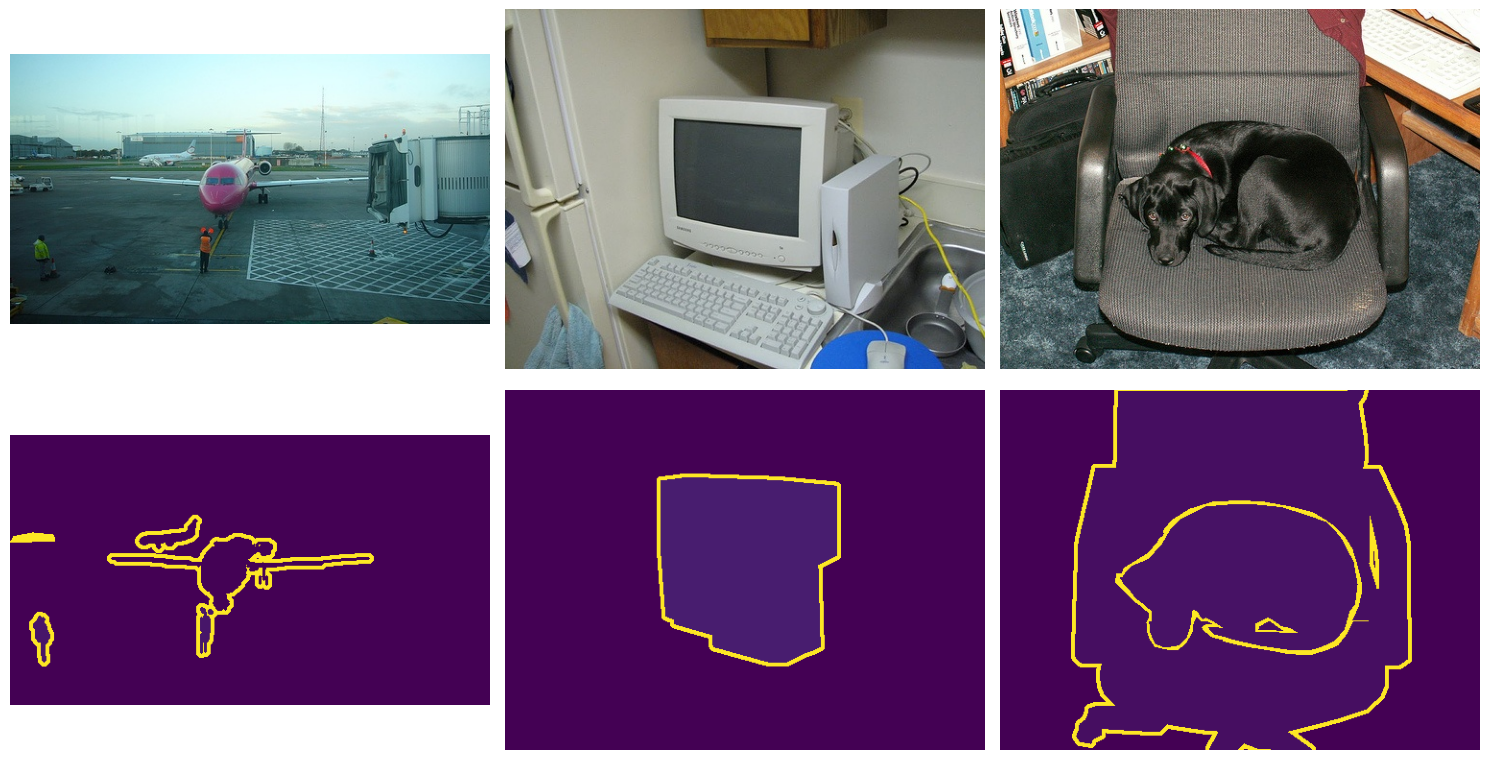

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx in range(3):
    img, mask = voc_segmentation[idx]
    img_vis = img.permute(1, 2, 0).cpu().numpy()
    mask_vis = mask.squeeze().cpu().numpy()

    axes[0, idx].imshow(img_vis)
    axes[0, idx].axis('off')

    axes[1, idx].imshow(mask_vis, cmap='viridis')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()


> Em geral, as abordagens de segmentação baseada em Redes Neurais não utilizam camadas totalmente conectadas, em vez disso utilizando arquiteturas **totalmente convolucionais**. Até o final do curso, entenderemos melhor os benefícios disso.

100.0%


<class 'torch.Tensor'> <class 'int'>
torch.Size([3, 32, 32])


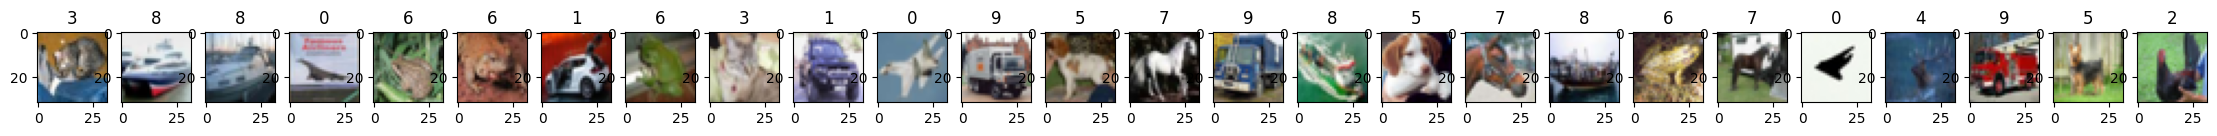

In [13]:
data = datasets.CIFAR10('./',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())


dado, rotulo = data[0]
print(type(dado), type(rotulo))

# Channel First: Padrão do torch
print(dado.size()) # C x H x W

fig, axs = plt.subplots(1,26, figsize=(28, 4))

for i in range(26):
  dado, rotulo = data[i]
  # Lembre-se que imagens são carregadas na dimensão C x H x W
  # é preciso permutar as dimensões para plot.
  axs[i].imshow(dado.permute(1,2,0))
  axs[i].set_title(str(rotulo))

plt.show()